# **Getting the features**

In [4]:
%env CUDA_VISIBLE_DEVICES=0
!rm -rf .cache *.bz2 utils.py*
#!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/SPECTRAL_STACK50_NFILT40_c11783_features.csv.bz2
!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv.bz2 ||  echo "PECTRAL_STACKFREE_NFILT40_c74e01_features.csv.bz2 not found"
!wget --quiet -c https://github.com/jubenjum/mcr_exp/raw/master/utils.py || echo "utils.py not found"

!bunzip2 -f *.bz2

env: CUDA_VISIBLE_DEVICES=0


In [0]:
from google.colab import files

from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

%matplotlib inline


# **Load/prepare features and calls**

In [0]:
# some common values
n_filters = 40

n_dimensions = 20

species = ['BM-Kenya', 'BM-Uganda', 'PN', 'TT', 'CB', 'CL']

to_remove = ['x', 'A', 'A*', 'Nscrm', 'BO', 'BS', 'Bw', 'C', 'K+/W+']

call2species = {'1':'PN', '2':'PN', '3':'PN', '4':'PN', 
                'A':'BM-Kenya', 'A*':'BM-Kenya', 'KA':'BM-Kenya', 'KATR':'BM-Kenya', 'Nscrm':'BM-Kenya', 'PY':'BM-Kenya', 'BO':'BM-Kenya',
                'h':'BM-Uganda', 'p':'BM-Uganda',
                'A_titi':'TT', 'B':'TT', 'BS':'TT', 'Bw':'TT',  'C':'TT', 'H':'TT', 'x':'TT',  
                'H':'CB', 'K':'CB', 'K+':'CB', 'W':'CB', 'W+':'CB', 'K+/W+':'CB',                 
                'r':'CL', 's':'CL'}


# reading features and labels, in the csv file the first column are the calls/labels 
# the rest are features
features_, labels_ = read_csv('SPECTRAL_STACKFREE_NFILT40_c74e01_features.csv')            
labels = pd.DataFrame(labels_).values.reshape(-1)
features = pd.DataFrame(features_).values
features = normalize(features)

samples, size_features =  features.shape
timesteps, input_dim = size_features/n_filters, n_filters

# reshaping the features for LSTM model
features = features.reshape(samples, timesteps, input_dim)

# only to have the names similar to other people's code
x = features.astype(np.float32)
y = LabelEncoder().fit(labels).transform(labels)

# shuffling features and labels to have mixed species
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
shuffled_labels = labels[indices]

# if you do train/test splits
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.8, stratify=y)



# **Training Triplet-loss LSTM-embeddings**

In [0]:
# TODO: I'll include the references!!

def get_triples_indices(grouped, n):
    '''balanced triplets'''
    num_classes = len(grouped) 
    positive_labels = np.random.randint(0, num_classes, size=n)
    negative_labels = (np.random.randint(1, num_classes, size=n) + positive_labels) % num_classes
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    
    return np.asarray(triples_indices)


def get_triples_data(x, grouped, n):
    indices = get_triples_indices(grouped, n)
    return x[indices[:,0]], x[indices[:,1]], x[indices[:,2]]


def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
        
    loss = positive_distance - negative_distance
    
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
        
    return K.mean(loss)

        
def build_model(input_shape):
    timesteps, input_dim = input_shape
    base_input = Input(shape=(timesteps, input_dim))
    #base_input = Input(input_shape)
    x = Masking(mask_value=0.0)(base_input)
    x = LSTM(20, return_sequences=False)(x)
    x = Dense(2, activation='linear')(x)
    embedding_model = Model(base_input, x, name='embedding')
    
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    triplet_model.compile(loss=None, optimizer='rmsprop')

    return embedding_model, triplet_model        


def triplet_generator(x, y, batch_size):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
        
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               None)
        
batch_size = 100

steps_per_epoch = 32

epochs = 100

embedding_model, triplet_model = build_model((timesteps, input_dim))

encoder_layer = 2

#plotter = Plotter(embedding_model, x, y, labels, encoder_layer, epochs, 
#                  'cosine_proximity','val_cosine_proximity', 
#                  'triplet_loss_embeddings')

history = triplet_model.fit_generator(triplet_generator(train_x, train_y, batch_size),
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=epochs,
                                      verbose=1)
                                      #callbacks=[plotter])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:69: UserWarning: Output "embedding" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "embedding" during training.


Epoch 1/200
32/32 [==============================] - 79s 2s/step - loss: 0.5962
Epoch 2/200
32/32 [==============================] - 74s 2s/step - loss: 0.4660
Epoch 3/200
32/32 [==============================] - 73s 2s/step - loss: 0.4184
Epoch 4/200
32/32 [==============================] - 70s 2s/step - loss: 0.3632
Epoch 5/200
32/32 [==============================] - 74s 2s/step - loss: 0.3249
Epoch 6/200
32/32 [==============================] - 74s 2s/step - loss: 0.3007
Epoch 7/200
32/32 [==============================] - 77s 2s/step - loss: 0.2871
Epoch 8/200
32/32 [==============================] - 74s 2s/step - loss: 0.2434
Epoch 9/200
 8/32 [======>.......................] - ETA: 1:00 - loss: 0.233032/32 [==============================] - 77s 2s/step - loss: 0.2189
Epoch 10/200
32/32 [==============================] - 75s 2s/step - loss: 0.2263
Epoch 11/200
32/32 [==============================] - 75s 2s/step - loss: 0.2128
Epoch 12/200
32/32 [==============================] -

# **Computing embeddings and plotting the features**

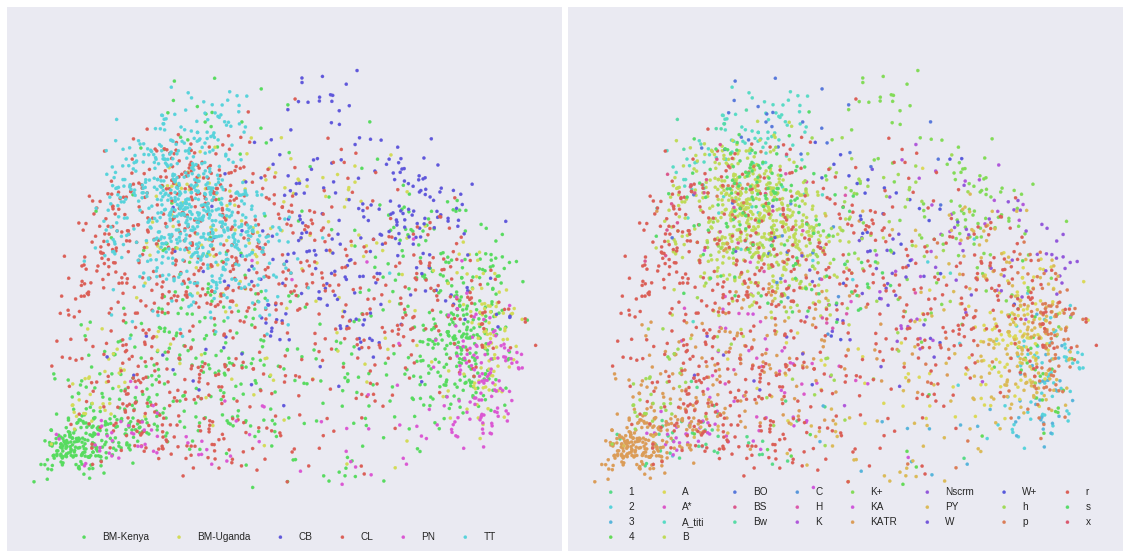

In [20]:
get_layer = K.function([embedding_model.layers[0].input], [embedding_model.layers[2].output])
embeddings_ = get_layer([x])[0]
triplet_lstm_embeddings = to_pandas_(embeddings_, labels)
plot_labels(triplet_lstm_embeddings, 'triplet-loss LSTM-embeddings')

# **ABX plots**

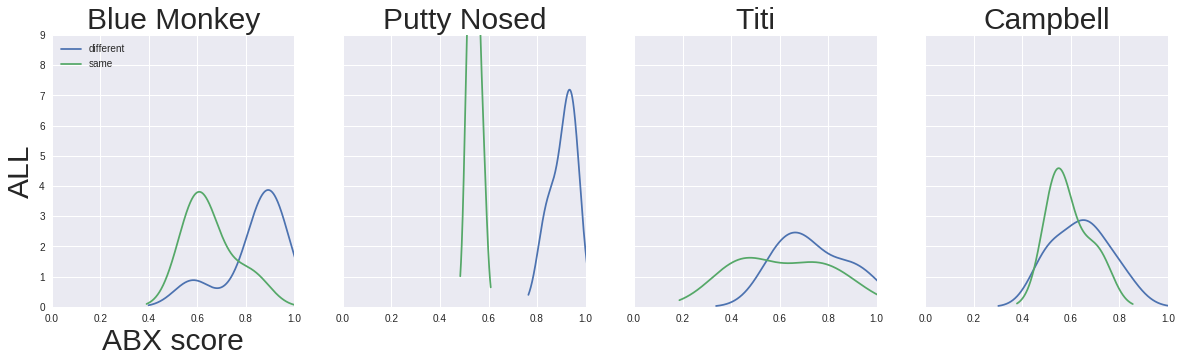

In [21]:
plot_abx(embeddings_, labels)

# **Save & download new features**

In [0]:
embeddings_features = np.append(labels.reshape(-1,1), embeddings_, axis=1)
fname = "triplet_loss_lstm_embeddings_features_{:02d}D.csv".format(n_dimensions)
pd.DataFrame(embeddings_features).to_csv(fname)
files.download(fname)